# Language Modeling


Let's try the language modeling task by using chariot and Tensorflow.

* Download the WikiText2 dataset by chazutsu.
* Preprocess text8 by chariot.
* Make model by TensorFlow (use tf.keras).
* Train & evaluate the model.

This tutorial needs following libraries.

* chazutsu
* tensorflow
* matplotlib


## Prepare the packages

In [1]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
def set_path():
    if "../" not in sys.path:
        sys.path.append("../")
    root_dir = Path.cwd()
    return root_dir

ROOT_DIR = set_path()

## Download the Language Modeling Data

In [4]:
import chazutsu
from chariot.storage import Storage

storage = Storage.setup_data_dir(ROOT_DIR)
r = chazutsu.datasets.WikiText2().download(storage.data_path("raw"))

Read resource from the existed resource(if you want to retry, set force=True).


In [5]:
r.train_data().head(3)

,sentence
0,= Valkyria Chronicles III =
1,Senjō no Valkyria 3 : <unk> Chronicles ( Japa...
2,"The game began development in 2010 , carrying..."


## Preprocess the review text by chariot.

### Make preprocessor

In [6]:
import chariot.transformer as ct
from chariot.preprocessor import Preprocessor


lm_processor = Preprocessor(
                    text_transformers=[
                        ct.text.UnicodeNormalizer(),
                        ct.text.LowerNormalizer()
                    ],
                    tokenizer=ct.Tokenizer(lang=None),
                    vocabulary=ct.Vocabulary(min_df=5))

preprocessed = lm_processor.fit_transform(r.valid_data())

In [7]:
print(len(lm_processor.vocabulary.get()))

4321


## Make model by TensorFlow

In [8]:
from tensorflow.python import keras as K


vocab_size = lm_processor.vocabulary.count
embedding_size = 50
hidden_size = 75

def make_model():
    model = K.Sequential()
    model.add(K.layers.Embedding(input_dim=vocab_size, output_dim=embedding_size))
    model.add(K.layers.LSTM(hidden_size))
    model.add(K.layers.Dense(vocab_size, activation="softmax"))
    return model

model = make_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

## Train the Model

In [9]:
from chariot.feeder import LanguageModelFeeder


feeder = LanguageModelFeeder({"sentence": ct.formatter.ShiftGenerator()})
steps_per_epoch, generator = feeder.make_generator(preprocessed, batch_size=32, sequence_length=8,
                                                   sequencial=False)

test_data = lm_processor.transform(r.test_data())
t_feeder = LanguageModelFeeder({"sentence": ct.formatter.ShiftGenerator()})
t_steps_per_epoch, t_generator = feeder.make_generator(test_data, batch_size=32, sequence_length=8,
                                                       sequencial=False)

metrics = model.fit_generator(generator(), steps_per_epoch,
                              validation_data=t_generator(), validation_steps=t_steps_per_epoch,
                              epochs=20, verbose=0)

c:\users\ico\documents\works\chariot\venv\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


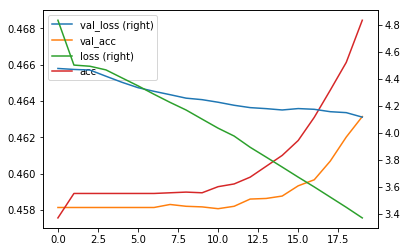

In [10]:
result = pd.DataFrame.from_dict(metrics.history)
result.plot.line(secondary_y=["loss", "val_loss"])

## Try generating the Text

In [14]:
def generate_text(seed_text, lm_processor, model, sequence_length=10, iteration=20):
    preprocessed = lm_processor.transform([seed_text])[0]

    def pad_sequence(tokens, length):
        if len(tokens) < length:
            pad_size = length - len(tokens)
            return tokens + [lm_processor.vocabulary.pad] * pad_size
        elif len(tokens) > length:
            return tokens[-length:]
        else:
            return tokens

    for _ in range(iteration):
        x = pad_sequence(preprocessed, sequence_length)
        y = model.predict([x])[0]
        w = np.random.choice(np.arange(len(y)), 1, p=y)[0]
        preprocessed.append(w)
    
    decoded = lm_processor.inverse_transform([preprocessed])
    text = " ".join(decoded[0])

    return text

In [15]:
generate_text("when you", lm_processor, model)

'when you no three athletes passed his losing by @@UNKNOWN@@ them championship were position well @@UNKNOWN@@ across @@UNKNOWN@@ soviet january approaching wide'

In [16]:
generate_text("i wish to", lm_processor, model)

'i wish @@UNKNOWN@@ also were @@UNKNOWN@@ later but african an heavily command superstructure hotel one country least he @@UNKNOWN@@ planned moved rather come'